<a href="https://colab.research.google.com/github/Jaimon12/Ames-Housing-Classification/blob/main/Ames_Housing_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# 2. Load the Ames Housing Dataset
df = pd.read_csv("AmesHousing.csv")
df = df.copy()

# 3. Target Engineering: Classification Problem
median_price = df["SalePrice"].median()
df["Price_Class"] = (df["SalePrice"] >= median_price).astype(int)  # 1 = Expensive, 0 = Affordable

# Drop SalePrice for classification
df.drop("SalePrice", axis=1, inplace=True)


In [ ]:
# 4. Handle Missing Values (Simplified)
# Drop columns with > 30% missing values
threshold = 0.3
df = df[df.columns[df.isnull().mean() < threshold]]

# Fill remaining missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)


In [ ]:
# 5. Encode Categorical Variables
cat_cols = df.select_dtypes(include='object').columns

le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le


In [ ]:
# 6. Train-Test Split
X = df.drop("Price_Class", axis=1)
y = df["Price_Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# 7. Train Classifier Models
log_reg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# 8. Evaluate Models
def evaluate(model, X_test, y_test, name):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds)
    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(report)
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

=== Logistic Regression ===
Accuracy: 0.8328
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       289
           1       0.82      0.86      0.84       297

    accuracy                           0.83       586
   macro avg       0.83      0.83      0.83       586
weighted avg       0.83      0.83      0.83       586



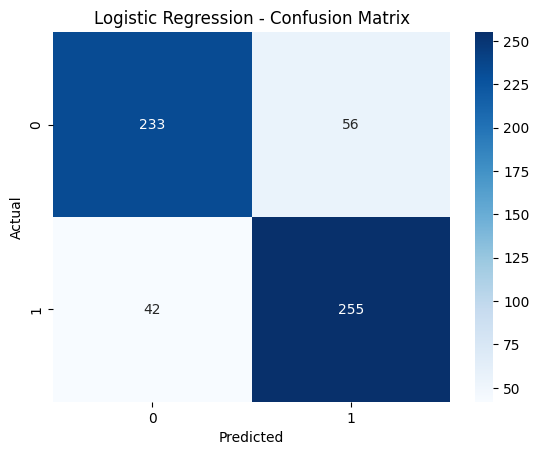

=== Random Forest ===
Accuracy: 0.9232
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       289
           1       0.95      0.90      0.92       297

    accuracy                           0.92       586
   macro avg       0.92      0.92      0.92       586
weighted avg       0.92      0.92      0.92       586



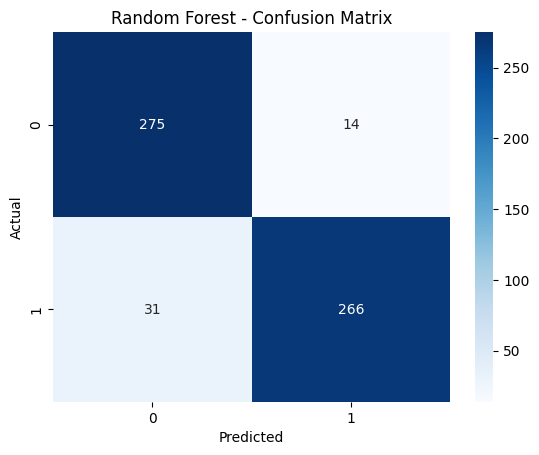

=== XGBoost ===
Accuracy: 0.9266
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       289
           1       0.93      0.93      0.93       297

    accuracy                           0.93       586
   macro avg       0.93      0.93      0.93       586
weighted avg       0.93      0.93      0.93       586



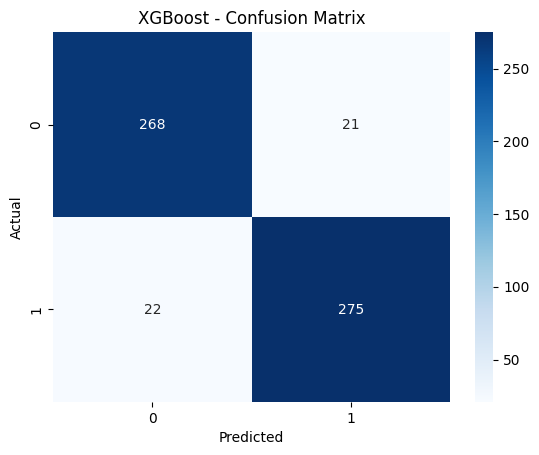

In [ ]:
evaluate(log_reg, X_test, y_test, "Logistic Regression")
evaluate(rf, X_test, y_test, "Random Forest")
evaluate(xgb, X_test, y_test, "XGBoost")


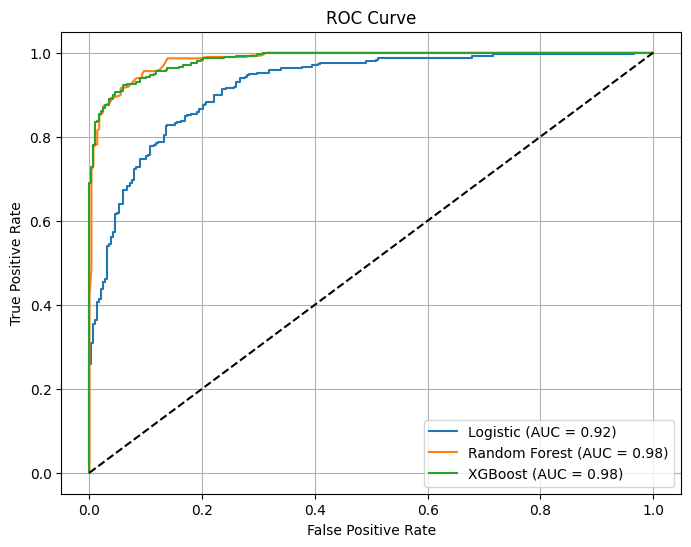

In [ ]:
# 9. ROC Curve
plt.figure(figsize=(8, 6))
for name, model in zip(["Logistic", "Random Forest", "XGBoost"], [log_reg, rf, xgb]):
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


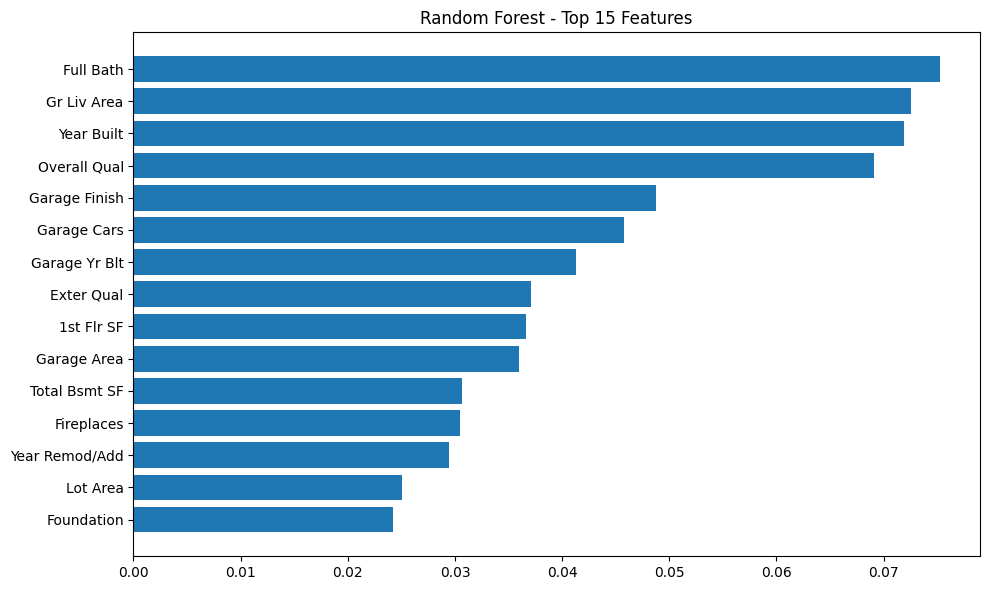

In [ ]:
# 10. Feature Importance (Optional)
importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Random Forest - Top 15 Features")
plt.tight_layout()
plt.show()
